# Modelling and Evaluating Notebook

### Objectives
* Answer second business requirement:
  The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

### Inputs
* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* inputs/cherry_leaves_dataset/cherry-leaves/test
* image shape embeddings

### Outputs
* Images distribution plot in train, validation and test set
* Image augmentation
* Class indices to change prediction inference in labels
* ML model creation and training
* Saving model
* Ploting learning curve for model performance
* Model evaluation on pickle file
* Prediction on the randome image file

### Additional Comments
* No additional comments

---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/milestone-project-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/milestone-project-mildew-detection-in-cherry-leaves'

## Set Input Directories

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directories

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['powdery_mildew', 'healthy']


## Set Image Shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, validation and test set

Image distribution: Loop through data (sets), determine image frequency and plot results on bar graph

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images


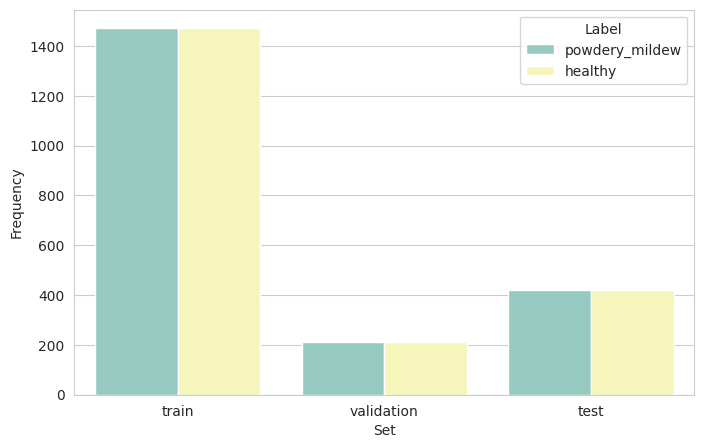

In [13]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])


folders = ['train', 'validation', 'test']

# Iterate through folders and labels to count images
for folder in folders:
    for label in labels:
        folder_path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(folder_path))
        df_freq = df_freq.append({'Set': folder, 'Label': label, 'Frequency': num_images}, ignore_index=True)
        print(f"* {folder} - {label}: {num_images} images")

# Plot the distribution of labels
sns.set_style("whitegrid")
sns.set_palette("Set3")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation

By looking at the plot graf above we can notice that the number of images in train set is not sufficient for deep neural network learning model. To solve this problem we will increase the number of images by generating modified versions of the existing images. Process is called Image Augmentation. That will also help models generalize more effectively and improve their ability to recognize and interpret new images.

---

### ImageDataGenerator

### Import and Initialize ImageDataGenerator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

In [16]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [17]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [18]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented images

* Augmented training image

(20, 256, 256, 3)


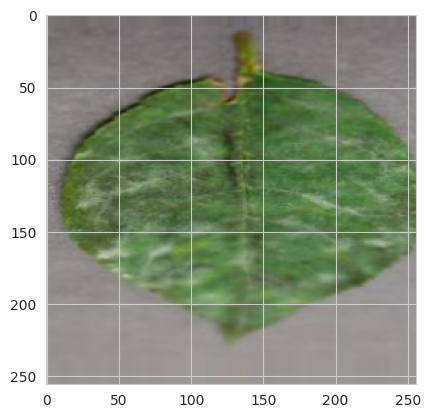

(20, 256, 256, 3)


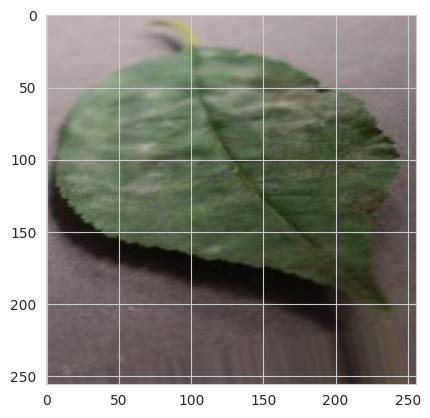

(20, 256, 256, 3)


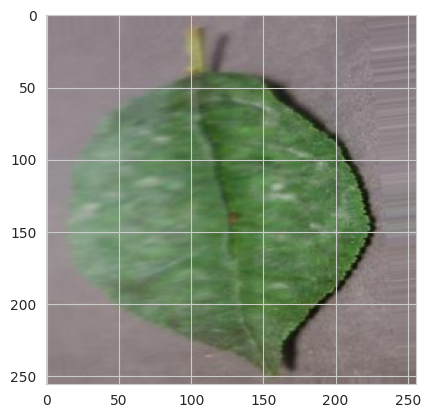

In [19]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

* Augmented validation image

(20, 256, 256, 3)


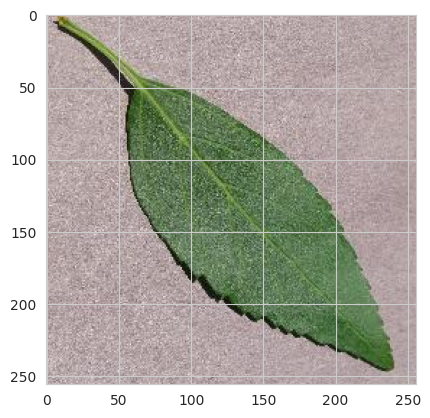

(20, 256, 256, 3)


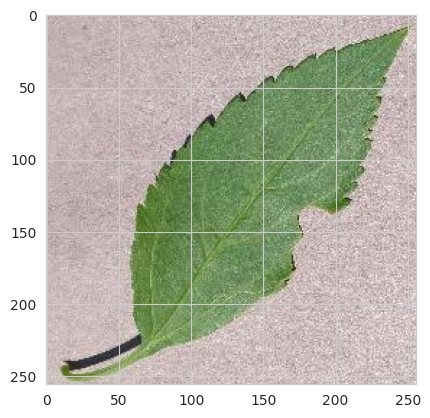

(20, 256, 256, 3)


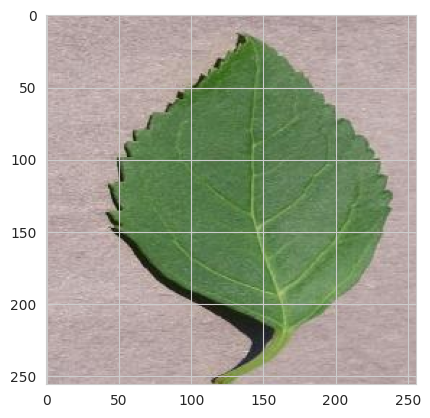

In [20]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


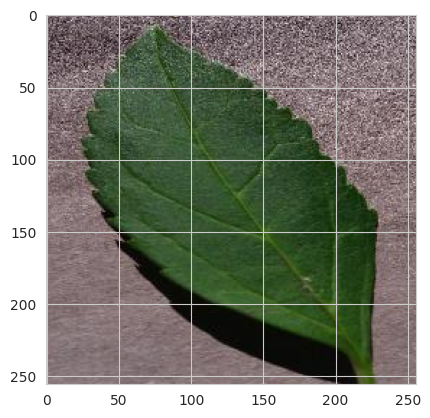

(20, 256, 256, 3)


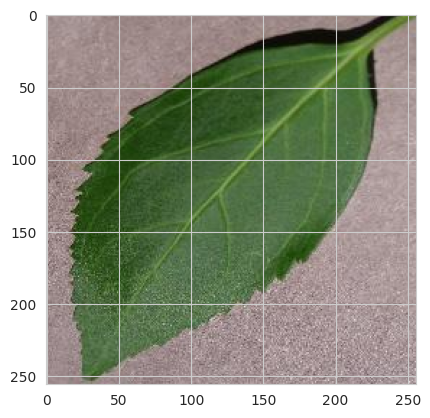

(20, 256, 256, 3)


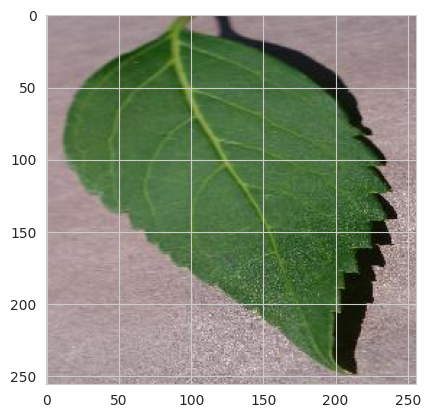

In [25]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[1])
    plt.show()

In [24]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']